# Analysis function

In [24]:
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq
from scipy.integrate import odeint
from matplotlib.patches import Patch
from scipy.stats import linregress

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
  
def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std 
  
def completion_at_time(data,
                      baseline_data,
                      triggered_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      baseline_conditions,
                      triggered_conditions,
                      experimental_level,
                      base_line_level,
                      triggered_level,
                      verbose = False):


  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(baseline_data, baseline_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(triggered_data, triggered_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)

def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

def timeToSec(time_string):
  split_string = time_string.split(":")
  return int(split_string[0])*3600 + int(split_string[1])*60 + int(split_string[2])

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out
  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)
    
  
def getTriplicatesJackknife(startTime, offset, level, x, data, conditions, fit):
    """
    Leave-one-out version of getAverageCurve.
    Returns 3 average curves and their standard deviations, each leaving out one replicate.

    Args:
    - startTime (float): Start time for truncating the curves.
    - offset (float): Time offset to apply to x values.
    - level: Condition label to match columns.
    - x (list or array): Full time array.
    - data (DataFrame): Curve data in columns.
    - conditions (dict): Mapping of column names to experimental conditions.
    - fit (tuple): Background subtraction and normalization (offset, scale).

    Returns:
    - x_vals (list): Timepoints corresponding to returned curves.
    - y_curves (list of 3 lists): Each is a leave-one-out average curve.
    - y_stds   (list of 3 lists): Each is the std deviation matching the y_curves.
    """
    y_all = []
    for i, c in enumerate(data.columns):
        if i >= 1 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_all.append(ynew)

    if len(y_all) != 3:
        print(conditions[level])
        for y in y_all:
          print(y[0:10])
        raise ValueError(f"Expected 3 replicates, found {len(y_all)} for level {level}")

    x_vals = [i + offset - startTime for i in x if i >= startTime]

    y_curves = []
    y_stds = []

    for i in range(3):
        subset = [y for j, y in enumerate(y_all) if j != i]
        avg, std = average_and_std(subset)
        y_curves.append(avg)
        y_stds.append(std)

    return x_vals, y_curves, y_stds


def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()

# Importing data

In [25]:
UW_backgr = pd.read_csv("UW_backgr.csv")
conditions_UW_backgr = {'R alone' : ['B2', 'C2', 'D2'],
'N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B3', 'C3', 'D3'],
'R(nn) alone' : ['E2', 'F2', 'G2'],
'N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E3', 'F3', 'G3']}
offset_UW_backgr = 0
t_UW_backgr = [offset_UW_backgr  + timeToSec(i) for i in list(UW_backgr['Time'].values)]
UW_trig = pd.read_csv("UW_trig.csv")
conditions_UW_trig = {'R background' : ['E9', 'F9', 'G9'],
              'no background nat' : ['E13', 'F13', 'G13'],
              'Trig N50_25uM nat' : ['E11', 'F11', 'G11'],
              'R(nn) background' : ['H9', 'I9', 'J9'],
              'no background nn' : ['H13', 'I13', 'J13'],
              'Trig N50_25uM nn' : ['H11', 'I11', 'J11']}
offset_UW_trig = 140
t_UW_trig = [offset_UW_trig  + timeToSec(i) for i in list(UW_trig['Time'].values)]


UW_rep = pd.read_csv("UW_rep.csv")
conditions_UW_rep = {'R background' : ['E8', 'F8', 'G8'],
              'no background nat' : ['E12', 'F12', 'G12'],
              'Rep N50_25uM nat' : ['E10', 'F10', 'G10'],
              'R(nn) background' : ['H8', 'I8', 'J8'],
              'no background nn' : ['H12', 'I12', 'J12'],
              'Rep N50_25uM nn' : ['H10', 'I10', 'J10']}
offset_UW_rep = 140
t_UW_rep = [offset_UW_rep + timeToSec(i) for i in list(UW_rep['Time'].values)]


UW_no = pd.read_csv("UW_no.csv")
conditions_UW_no = {'no background nat' : ['E3', 'F3', 'G3'],
'R background' : ['E4', 'F4', 'G4'],
'No N50_25uM nat' : ['E5', 'F5', 'G5'],
'no background nn' : ['H3', 'I3', 'J3'],
'R(nn) background' : ['H4', 'I4', 'J4'],
'No N50_25uM nn' : ['H5', 'I5', 'J5']}
offset_UW_no = 140
t_UW_no = [offset_UW_no + timeToSec(i) for i in list(UW_no['Time'].values)]


TUM_controls = pd.read_csv("TUM_controls.csv")
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3'],
                          'no background nat' : ['OneStep_1',	'OneStep_2',	'OneStep_3'],
                          'no background nn' : ['OneStep(nn)_1',	'OneStep(nn)_2',	'OneStep(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_no = pd.read_csv("TUM_no.csv")
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]

TUM_trig = pd.read_csv("TUM_trig.csv")
conditions_TUM_trig = {'Trig inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Trig inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Trig inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Trig inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Trig inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Trig inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Trig inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Trig inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_rep = pd.read_csv("TUM_rep.csv")
conditions_TUM_rep = {'Rep inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Rep inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Rep inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Rep inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Rep inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Rep inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Rep inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Rep inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_rep = 0
t_TUM_rep = [int(t) + offset_TUM_rep for t in TUM_rep['time'].values]

# 6 hr rate constants (1 parameter)

In [26]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

In [27]:
number_of_points = 6*3600//60

## Fitting

### Controls

#### Natural

Fitted kf = 7.6e+03 ± 5.4e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/944145527.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


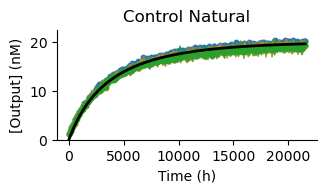

In [28]:
import math



data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])



format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


k_control_nat = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



#### NN

Fitted kf = 2.2e+04 ± 8.1e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/2764391458.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


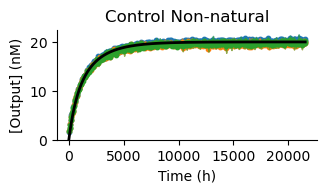

In [29]:



data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


k_control_nn = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

#plt.savefig('control_nnn_k.svg', dpi = 400)

plt.show()



### No incubation
         

#### Nat

Fitted kf = 2.8e+03 ± 1.4e+02
Fitted kf = 1.1e+03 ± 5.8e+01
Fitted kf = 2.9e+02 ± 3.1e+01
Fitted kf = 1.1e+02 ± 5.4e+00


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/2191573928.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


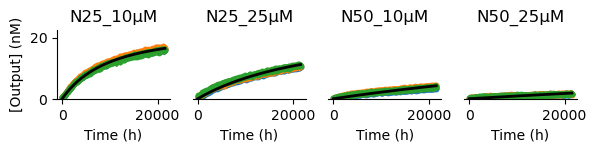

In [31]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nat = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  k_no_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



#### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/1409115197.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 9.1e+03 ± 3.8e+02
Fitted kf = 4.8e+03 ± 1.9e+02
Fitted kf = 2.1e+03 ± 2.0e+02
Fitted kf = 5.9e+02 ± 2.3e+01


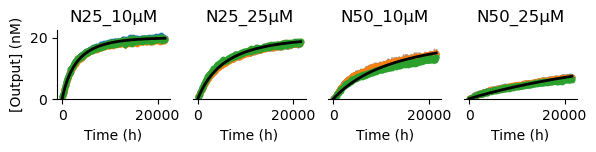

In [32]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nn = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)

  k_no_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_noinc.svg', dpi = 500, transparent=True)
plt.show()



### Trig
         

#### Nat

Fitted kf = 2.8e+03 ± 3.6e+01
Fitted kf = 1.2e+03 ± 2.2e+01
Fitted kf = 2.6e+02 ± 1.9e+00
Fitted kf = 7.3e+01 ± 2.7e+00


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/4251823191.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


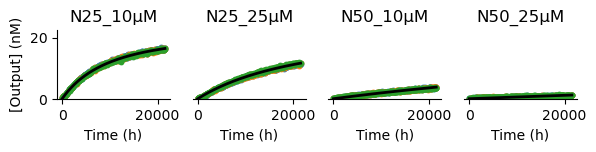

In [33]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nat = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)

  k_trig_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')
#plt.savefig('TUM_nat_trig.svg', dpi = 500, transparent=True)

plt.show()

#### NN

Fitted kf = 1.0e+04 ± 1.2e+02
Fitted kf = 4.2e+03 ± 1.1e+02
Fitted kf = 1.2e+03 ± 2.3e+01
Fitted kf = 3.4e+02 ± 2.4e+00


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/394579532.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


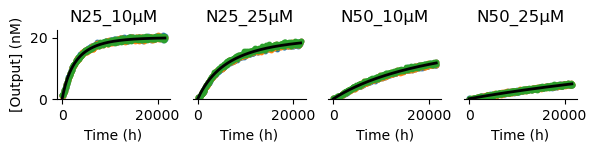

In [34]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}


curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [4,5,6,7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nn = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)
  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)

  k_trig_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")



  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_trig.svg', dpi = 500, transparent=True)
plt.show()


### Rep
         

#### Nat

Fitted kf = 2.8e+03 ± 3.6e+01
Fitted kf = 1.2e+03 ± 2.2e+01
Fitted kf = 2.6e+02 ± 1.9e+00
Fitted kf = 7.3e+01 ± 2.7e+00


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/1488850663.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


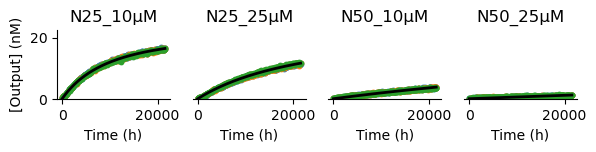

In [35]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']

data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e2


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nat = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)
  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)

  k_rep_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")



  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_rep.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 1.0e+04 ± 1.2e+02
Fitted kf = 4.2e+03 ± 1.1e+02
Fitted kf = 1.2e+03 ± 2.3e+01
Fitted kf = 3.4e+02 ± 2.4e+00


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/3475420629.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


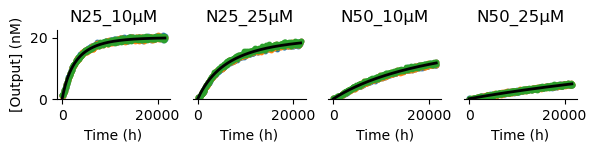

In [36]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [4, 5, 6, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x

# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nn = []
for i,a in enumerate(ax):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)

  k_rep_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")



  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_rep.svg', dpi = 500, transparent=True)
plt.show()


# UW N50_25uM data

In [13]:
fit_nat = [789.333333, (6701.566667-789.333333)/20]
fit_nn =  [278.600000, (7651.433333	-278.600000)/20]


Fitted kf = 5.7e+02 ± 1.2e+01


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/355401821.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


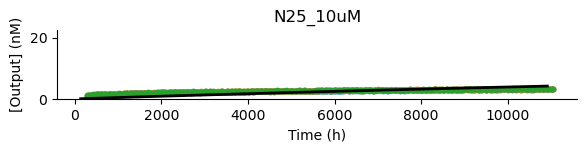

In [14]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nat = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_no_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 3.0e+03 ± 6.8e+01


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/1532830905.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


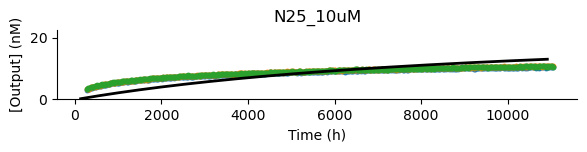

In [15]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nn = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_no_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/670423003.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 3.1e+02 ± 9.1e+00


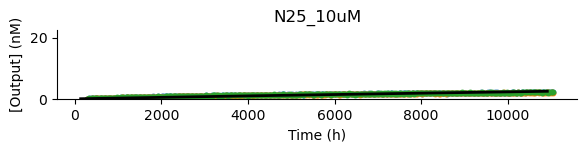

In [16]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nat = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_trig_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 1.7e+03 ± 2.6e+01


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/3148126748.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


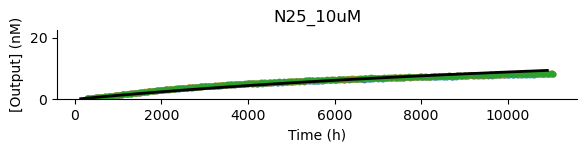

In [17]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nn = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_trig_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/4175665474.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 5.8e+02 ± 1.7e+01


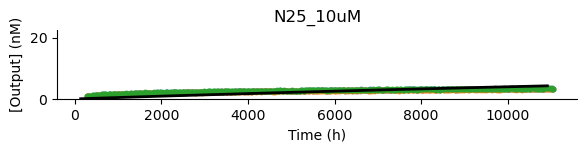

In [18]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_rep[0:number_of_points]
conditions = conditions_UW_rep
levels = list(conditions.keys())
offset = offset_UW_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nat = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_rep_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_51564/4197957942.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 3.6e+03 ± 1.3e+01


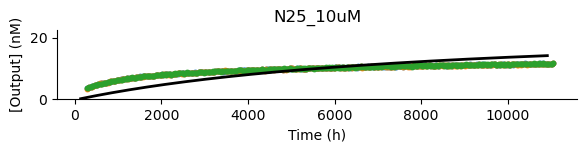

In [19]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = UW_rep[0:number_of_points]
conditions = conditions_UW_rep
levels = list(conditions.keys())
offset = offset_UW_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nn = []
for i, a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_rep_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



## Summary Data

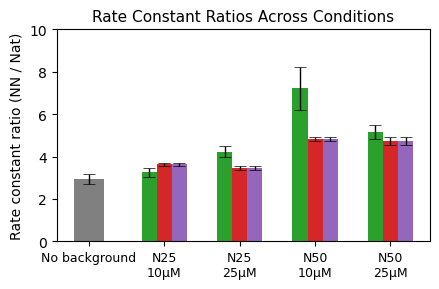

In [20]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation', 'Trigger incubated', 'Reporter incubated']
colors = [color_scheme[2], color_scheme[3], color_scheme[4]]
bar_width = 0.2

# Control baseline (gray)
controls = [k_control_nat, k_control_nn]
base = controls[1][0][0] / controls[0][0][0]
e_base = prop_err(controls[1][0], controls[0][0])

# Prepare experimental data
no = [k_no_nat, k_no_nn]
trig = [k_trig_nat, k_trig_nn]
rep = [k_rep_nat, k_rep_nn]
systems = [no, trig, rep]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_control = 0
x_group_start = 1  # reserve space for control
x_group = np.arange(n_groups) + x_group_start  # center position for each group
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)

# Control bar
ax.bar(x_control, base, bar_width*2, yerr=e_base, color='gray', label='No background', error_kw=error_params)

# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = [x_control] + list(x_group)
x_labels = ['No background'] + group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('Rate constant ratio (NN / Nat)', fontsize=10)
ax.set_ylim(0, 10)
ax.set_title('Rate Constant Ratios Across Conditions', fontsize=11)

plt.tight_layout()
#plt.savefig("Onestep_InitK_grouped_barplot_err.svg", dpi=400)
plt.show()


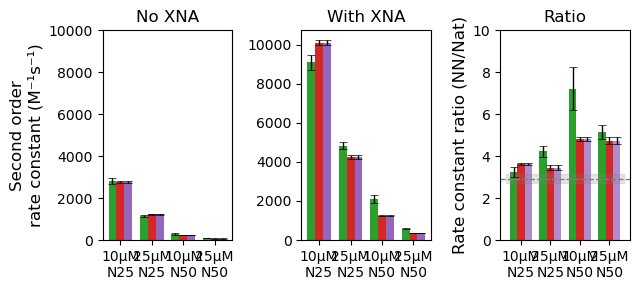

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(3)


def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

labels = [u"10\u03bcM\nN25", u"25\u03bcM\nN25", u"10\u03bcM\nN50", u"25\u03bcM\nN50"]
x = np.arange(len(labels))  # [0, 1, 2, 3]
bar_width = 0.25
# Group datasets by color group
datasets_panel0 = [
    # Format: (nat, nn, label, color, marker scale)
    (k_no_nat,
     k_no_nn,
      color_scheme[2], 1.0),
    (k_trig_nat,
     k_trig_nn,
     color_scheme[3], 1.0),
    (k_rep_nat,
     k_rep_nn,
     color_scheme[4], 1),
]


k_no_diff = [[k_no_nn[i][0]/k_no_nat[i][0], prop_err(k_no_nn[i], k_no_nat[i])] for i in range(len(k_no_nn))] #need to update with actual error propagation
k_trig_diff = [[k_trig_nn[i][0]/k_trig_nat[i][0], prop_err(k_trig_nn[i], k_trig_nat[i])] for i in range(len(k_trig_nn))]
k_rep_diff = [[k_rep_nn[i][0]/k_rep_nat[i][0], prop_err(k_rep_nn[i], k_rep_nat[i])] for i in range(len(k_rep_nn))]

datasets_panel1 = [
    (k_no_diff, 'No incubation', color_scheme[2], 1.0),
    (k_trig_diff, 'Trigger incubated', color_scheme[3], 1.0),
    (k_rep_diff, 'Reporter incubated', color_scheme[4], 0.75),
]



error_params = dict(ecolor='black', lw=1, capsize=3, capthick= 0.5)

for i, (nat_list, nn_list, color, scale) in enumerate(datasets_panel0):
    nat_y = [v[0] for v in nat_list]
    nat_err = [v[1] for v in nat_list]
    nn_y = [v[0] for v in nn_list]
    nn_err = [v[1] for v in nn_list]

    # x positions for this dataset
    dx = (i - 1) * bar_width  # shifts: -bar_width, 0, +bar_width
    ax[0].bar(x + dx, nat_y, width=bar_width, yerr=nat_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)
    ax[1].bar(x + dx, nn_y, width=bar_width, yerr=nn_err, error_kw=error_params,
              color=color, alpha=1 * scale)

# Panel 1: draw diff bars (no pairs)
for i, (diff_list, label, color, scale) in enumerate(datasets_panel1):
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    dx = (i - 1) * bar_width  # shift left, center, right
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err, error_kw=error_params,
              color=color, label=label, alpha=scale)


ax[2].axhline(y=k_control_nn[0][0]/k_control_nat[0][0], color='gray', linestyle='--', linewidth=1)
ax[2].fill_between([-0.5,3.5], [(k_control_nn[0][0]/k_control_nat[0][0]) - prop_err(k_control_nn[0], k_control_nat[0])]*2,
                  [(k_control_nn[0][0]/k_control_nat[0][0]) + prop_err(k_control_nn[0], k_control_nat[0])]*2,
                  color='gray', alpha=0.2)
# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=10)
    a.tick_params(axis='x', labelrotation=0)







ax[0].set_ylim(0,10000)
ax[2].set_ylim(0,10)

ax[0].set_ylabel('Second order\nrate constant (M⁻¹s⁻¹)', fontsize=12)

ax[2].set_ylabel('Rate constant ratio (NN/Nat)', fontsize=12)



ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)



plt.tight_layout()
plt.savefig('NAR_TUM_onestep_k.svg', dpi=400)
plt.show()


[5.154856259399516, 5.2950189420865375] [0.3146467798316134, 0.16293829764336434]
[4.7424874088865545, 5.36013367043313] [0.17994686793271147, 0.17748598466199303]
[4.742476934623754, 6.264962156455392] [0.1799609191747555, 0.1881681187796517]


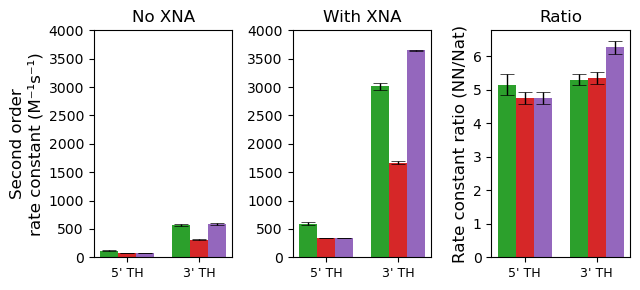

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(3)

labels = ["5' TH", "3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

# Panel 0: No incubation
no_nat_data_together = [k_no_nat[3], UW_k_no_nat[0]]
no_nn_data_together = [k_no_nn[3], UW_k_no_nn[0]]
no_R_data_together = [[k_no_nn[3][0]/k_no_nat[3][0], prop_err(k_no_nn[3], k_no_nat[3])] , [UW_k_no_nn[0][0]/UW_k_no_nat[0][0], prop_err(UW_k_no_nn[0], UW_k_no_nat[0])]]

# Panel 1: Trigger incubated
trig_nat_data_together = [k_trig_nat[3], UW_k_trig_nat[0]]
trig_nn_data_together = [k_trig_nn[3], UW_k_trig_nn[0]]
trig_R_data_together = [[k_trig_nn[3][0]/k_trig_nat[3][0], prop_err(k_trig_nn[3], k_trig_nat[3])] , [UW_k_trig_nn[0][0]/UW_k_trig_nat[0][0], prop_err(UW_k_trig_nn[0], UW_k_trig_nat[0])]]

# Panel 2: Reporter incubated
rep_nat_data_together = [k_rep_nat[3], UW_k_rep_nat[0]]
rep_nn_data_together = [k_rep_nn[3], UW_k_rep_nn[0]]
rep_R_data_together = [[k_rep_nn[3][0]/k_rep_nat[3][0], prop_err(k_rep_nn[3], k_rep_nat[3])] , [UW_k_rep_nn[0][0]/UW_k_rep_nat[0][0], prop_err(UW_k_rep_nn[0], UW_k_rep_nat[0])]]

# Grouped data for each condition and panel
datasets_panel0 = [
    (no_nat_data_together, color_scheme[2], -bar_width),
    (trig_nat_data_together, color_scheme[3], 0),
    (rep_nat_data_together, color_scheme[4], bar_width),
]
datasets_panel1 = [
    (no_nn_data_together, color_scheme[2], -bar_width),
    (trig_nn_data_together, color_scheme[3], 0),
    (rep_nn_data_together, color_scheme[4], bar_width),
]
datasets_panel2 = [
    (no_R_data_together, color_scheme[2], -bar_width),
    (trig_R_data_together, color_scheme[3], 0),
    (rep_R_data_together, color_scheme[4], bar_width),
]


error_params = dict(ecolor='black', lw=1, capsize=5, capthick= 0.5)

# Plot nat
for data_list, color, dx in datasets_panel0:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Plot nn
for data_list, color, dx in datasets_panel1:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Plot diff
for data_list, color, dx in datasets_panel2:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    print(y, e)
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, )
    a.tick_params(axis='x')

ax[0].set_ylabel('Second order\nrate constant (M⁻¹s⁻¹)', fontsize=12)

ax[2].set_ylabel('Rate constant ratio (NN/Nat)', fontsize=12)

ax[0].set_ylim(0, 4000)
ax[1].set_ylim(0, 4000)


ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

plt.tight_layout()
plt.savefig('NAR_onestep_compare_k.svg', dpi=400)
plt.show()


## Overview

In [23]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation']
colors = [color_scheme[2]]
bar_width = 0.2



# Prepare experimental data
no = [kb_no_nat, kb_no_nn]
systems = [no]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_control = 0
x_group_start = 1  # reserve space for control
x_group = np.arange(n_groups) + x_group_start  # center position for each group
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)



# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = list(x_group)
x_labels =  group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('Rate constant ratio (NN / Nat)', fontsize=10)
ax.set_ylim(0, 5)
ax.set_title('Rate Constant Ratios Across Conditions', fontsize=11)

plt.tight_layout()
#plt.savefig("Onestep_InitK_grouped_barplot_err.svg", dpi=400)
plt.show()


NameError: name 'kb_no_nat' is not defined

# 15 point initial rates

In [ ]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

In [ ]:
number_of_points = 15

## Fitting

### Controls

#### Natural

Fitted kf = 4.6e+00 ± 9.1e-02


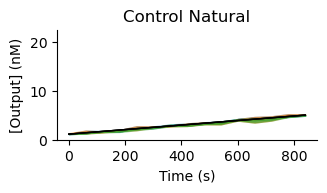

In [ ]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]





to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

initial_k = 2e1



res = []
slopes = []
intercepts = []
for curve in to_fit[0]:
  res += [linregress(x_trunc, curve)]
  slopes += [res[-1].slope]
  intercepts += [res[-1].intercept]


fitted_kf = np.mean(slopes)
param_sd_kf = np.std(slopes)
intercept = np.mean(intercepts)

def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nat = [fitted_kf, param_sd_kf]

control_nat_model = [intercept, fitted_kf]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 1

for i,curve in enumerate(to_fit[0]):
  ax.plot(x, model(x, intercept, fitted_kf), color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in curve], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[0][i])),np.array(curve), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc, curve, (np.array(curve)+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)


print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_title("Control Natural")
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_r.svg', dpi = 400)
plt.show()


Fitted kf = 1.0e+01 ± 4.4e-02


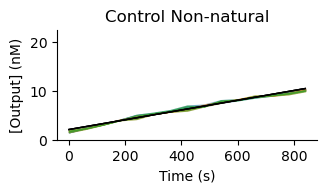

In [ ]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]



initial_k = 2e1


res = []
slopes = []
intercepts = []
for curve in to_fit[0]:
  res += [linregress(x_trunc, curve)]
  slopes += [res[-1].slope]
  intercepts += [res[-1].intercept]


fitted_kf = np.mean(slopes)
param_sd_kf = np.std(slopes)

intercept = np.mean(intercepts)



def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nn = [fitted_kf, param_sd_kf]

control_nn_model = [intercept, fitted_kf]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 1

for i,curve in enumerate(to_fit[0]):
  ax.plot(x, model(x, intercept, fitted_kf), color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in curve], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[0][i])),np.array(curve), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc, curve, (np.array(curve)+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)


print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_title("Control Non-natural")
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nnt_r.svg', dpi = 400)
plt.show()


#### NN

### No incubation
         

#### Nat

Fitted kf = 1.9e+00 ± 1.1e-01
Fitted kf = 8.1e-01 ± 8.4e-02
Fitted kf = 3.2e-01 ± 1.4e-01
Fitted kf = 1.9e-01 ± 4.2e-02


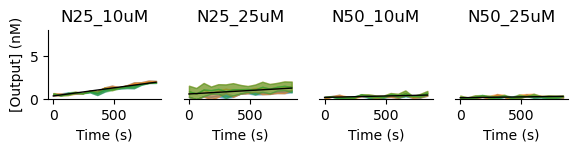

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_no[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 2, 4, 6]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]




def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_no_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_no_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc_r.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 5.6e+00 ± 2.2e-01
Fitted kf = 3.3e+00 ± 3.6e-01
Fitted kf = 2.0e+00 ± 8.3e-02
Fitted kf = 7.6e-01 ± 1.2e-02


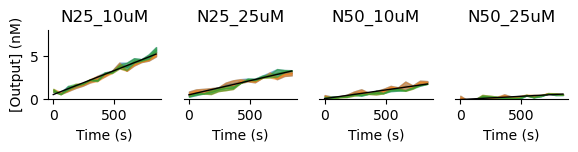

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_no[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [1, 3, 5, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_no_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_no_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_noinc_r.svg', dpi = 500, transparent=True)
plt.show()


### Trig
         

#### Nat

Fitted kf = 1.2e+00 ± 8.7e-03
Fitted kf = 4.1e-01 ± 9.2e-02
Fitted kf = 3.2e-01 ± 3.2e-02
Fitted kf = 1.8e-01 ± 1.0e-01


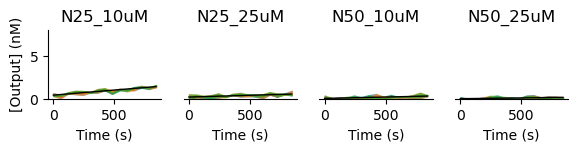

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_trig[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 1, 2, 3]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]

def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_trig_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_trig_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_trig_r.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 4.1e+00 ± 1.2e-01
Fitted kf = 1.8e+00 ± 9.8e-02
Fitted kf = 6.2e-01 ± 1.2e-01
Fitted kf = 3.2e-02 ± 1.1e-01


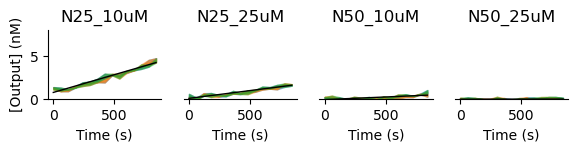

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_trig[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [4, 5, 6, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_trig_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")



  k_trig_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_trig_r.svg', dpi = 500, transparent=True)
plt.show()


### Rep
         

#### Nat

Fitted kf = 1.2e+00 ± 8.7e-03
Fitted kf = 4.1e-01 ± 9.2e-02
Fitted kf = 3.2e-01 ± 3.2e-02
Fitted kf = 1.8e-01 ± 1.0e-01


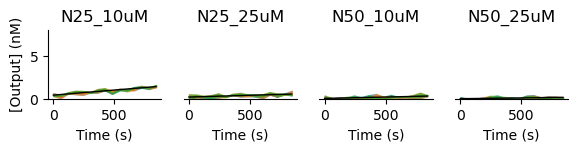

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_rep[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 1, 2, 3]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_rep_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_rep_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_rep_r.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 4.1e+00 ± 1.2e-01
Fitted kf = 1.8e+00 ± 9.8e-02
Fitted kf = 6.2e-01 ± 1.2e-01
Fitted kf = 3.2e-02 ± 1.1e-01


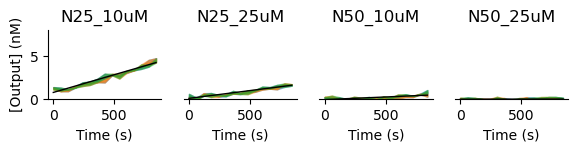

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_rep[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [4, 5, 6, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_rep_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_rep_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_rep_r.svg', dpi = 500, transparent=True)
plt.show()


## Summary Data

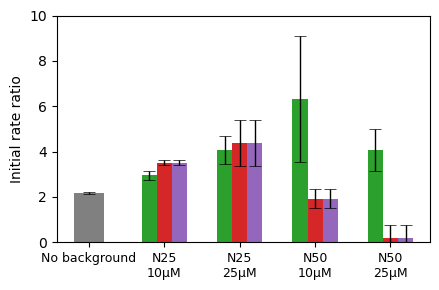

In [ ]:
# Define propagated error from slope + stderr
def prop_err(res_num, res_denom):
    return np.sqrt(((1 / res_denom[0]) * res_num[1]) ** 2 +
                   ((res_num[0] / (res_denom[0] ** 2)) * res_denom[1]) ** 2)

# Labels
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation', 'Trigger incubated', 'Reporter incubated']
colors = [color_scheme[2], color_scheme[3], color_scheme[4]]
bar_width = 0.2

# Control baseline
controls = [k_control_nat, k_control_nn]
base = controls[1][0] / controls[0][0]
e_base = prop_err(controls[1], controls[0])

# Collect fold changes and errors
no = [k_no_nat, k_no_nn]
trig = [k_trig_nat, k_trig_nn]
rep = [k_rep_nat, k_rep_nn]
systems = [no, trig, rep]

n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Bar positions
x_control = 0
x_group_start = 1
x_group = np.arange(n_groups) + x_group_start
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)

# Control bar
ax.bar(x_control, base, bar_width*2, yerr=e_base, color='gray', label='No background', error_kw=error_params)

# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], capsize=4, label=conditions[i], error_kw=error_params)

# X-axis

x_ticks = [x_control] + list(x_group)
x_labels = ['No background'] + group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

# Y-axis and labels
ax.set_ylabel('Initial rate ratio', fontsize=10)
ax.set_ylim(0, 10)

# Legend

plt.tight_layout()
#plt.savefig("Onestep_InitR_grouped_barplot_err.svg", dpi=400)
plt.show()


# Example figures

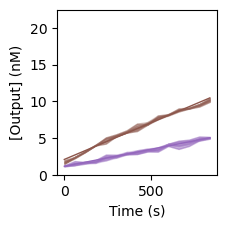

In [ ]:
number_of_points = 15

data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]



data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [np.array(c[1]) for c in curves]

x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nat = [res]

fig, ax = plt.subplots(1,1, figsize = (2,3))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.3
size = 5
line = 1

models = [control_nat_model, control_nn_model]
for i,curves in enumerate(to_fit):
  for j,c in enumerate(curves):
    ax.scatter(x_trunc,[1e9*i for i in c], color=color_scheme[4+(i%2)], s = 10)
    ax.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[4+(i%2)], alpha= alph)
    ax.fill_between(x_trunc,c,  (np.array(c)+np.array(stdDev[i][j])), color=color_scheme[4+(i%2)], alpha= alph)
  ax.plot(x, model(x, models[i][0], models[i][1]), color=color_scheme[4 + (i%2)],linewidth=line)

ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('[Output] (nM)')



#plt.savefig('ExampleLinear.svg', dpi = 400, transparent=True)
plt.show()


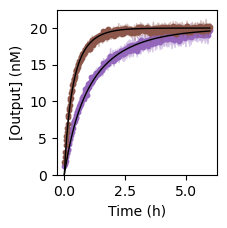

In [ ]:
number_of_points = 6*3600//60

data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getAverageCurve(start, offset, l, x, data, conditions, fit)[0],getAverageCurve(start, offset, l, x, data, conditions, fit)[1]]]
    stdDev += [getAverageCurve(start, offset, l, x, data, conditions, fit)[2]]


data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

for l in levels:
    curves += [[getAverageCurve(start, offset, l, x, data, conditions, fit)[0],getAverageCurve(start, offset, l, x, data, conditions, fit)[1]]]
    stdDev += [getAverageCurve(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [np.array(c[1])*1e-9 for c in curves]

x_trunc = curves[0][0]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, tfull, fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
]


k_control_nat = [res]

fig, ax = plt.subplots(1,1, figsize = (2,3))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.3
size = 5
line = 1

fitted = [7.505e+03, 2.218e+04]

xv = [t/3600 for t in x]
x_trunc = [t/3600 for t in x_trunc]

models = [control_nat_model, control_nn_model]
for i,c in enumerate(to_fit):
  ax.plot(xv,[i*1e9 for i in modelOneStep(fitted[i], x, fixed_params_list[i])], color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in c], color=color_scheme[4+(i%2)], s = 10)
  ax.fill_between(x_trunc,(np.array(curves[i][1])-np.array(stdDev[i])),curves[i][1], color=color_scheme[4+(i%2)], alpha= alph)
  ax.fill_between(x_trunc,curves[i][1],  (np.array(curves[i][1])+np.array(stdDev[i])), color=color_scheme[4+(i%2)], alpha= alph)

ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_ylabel('[Output] (nM)')


#plt.savefig('ExampleK_var.svg', dpi = 400, transparent=True)
plt.show()
